In [1]:
import sys 
import os
import numpy as np
import itertools
from dataclasses import dataclass, replace, field
from matplotlib import pyplot as plt
from typing import Optional, Mapping, Dict, Tuple, TypeVar, Iterable, Sequence, Callable, Iterator, List
from scipy.stats import norm



from rl.chapter2.simple_inventory_mrp import SimpleInventoryMRPFinite
from rl.chapter2.simple_inventory_mrp import InventoryState
from rl.function_approx import Tabular
from rl.markov_decision_process import TransitionStep
from rl.approximate_dynamic_programming import ValueFunctionApprox
from rl.distribution import Choose
from rl.iterate import last
from rl.markov_process import MarkovProcess, NonTerminal, State
from rl.distribution import Gamma, Distribution, Constant
import rl.td
import rl.monte_carlo
from itertools import islice
from collections import defaultdict
from pprint import pprint







user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0
user_gamma = 0.9

si_mrp = SimpleInventoryMRPFinite(
    capacity = user_capacity,
    poisson_lambda = user_poisson_lambda,
    holding_cost = user_holding_cost,
    stockout_cost = user_stockout_cost)

si_mrp.display_value_function(gamma = user_gamma)

{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.511,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.932,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.345,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.932,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.345,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.345}


In [36]:
traces = si_mrp.reward_traces(Choose(si_mrp.non_terminal_states))


value_dict = defaultdict(lambda: 0)
it = rl.monte_carlo.tabular_mc_prediction(traces = traces, approx_0 = value_dict, gamma = user_gamma)
    
num_traces = 60000


last_func = last(islice(it, num_traces))
pprint({s: round(value_dict[s], 3) for s in si_mrp.non_terminal_states})
 




{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.503,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.923,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.336,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.925,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.339,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.342}


In [35]:
import rl.iterate as iterate
from rl.chapter10.prediction_utils import fmrp_episodes_stream
from rl.chapter10.prediction_utils import unit_experiences_from_episodes


episode_length: int = 100
gamma: float = 0.9

value_dict = defaultdict(lambda: 0)
episodes = fmrp_episodes_stream(si_mrp)
td_experiences = unit_experiences_from_episodes(episodes, episode_length)

td_vfs = rl.td.tabular_td_prediction(transitions = td_experiences, approx_0 = value_dict, gamma = gamma)

num_episodes = 60000

final_td_vf = iterate.last(itertools.islice(td_vfs, episode_length*num_episodes))
pprint({s: round(value_dict[s], 3) for s in si_mrp.non_terminal_states})








{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.399,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.942,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.245,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.888,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.207,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.205}


In [23]:
td_state0 = list()
mc_state0 = list()
td_x = list()
mc_x = list()
count1 = 0
count2 = 0


value_dict = defaultdict(lambda: 0)
td_vfs_new = rl.td.tabular_td_prediction(transitions = td_experiences, approx_0 = value_dict, gamma = gamma)


for vf in itertools.islice(td_vfs_new, episode_length*num_episodes):
    td_state0.append(value_dict[si_mrp.non_terminal_states[0]])
    td_x.append(count1/episode_length)
    count1 += 1

value_dict = defaultdict(lambda: 0)
it_new = rl.monte_carlo.tabular_mc_prediction(traces = traces, approx_0 = value_dict, gamma = user_gamma)
   
    
for vf in itertools.islice(it_new, num_traces):
    mc_state0.append(value_dict[si_mrp.non_terminal_states[0]])
    mc_x.append(count2)
    count2 += 1

print(count1, count2)

600000 6000


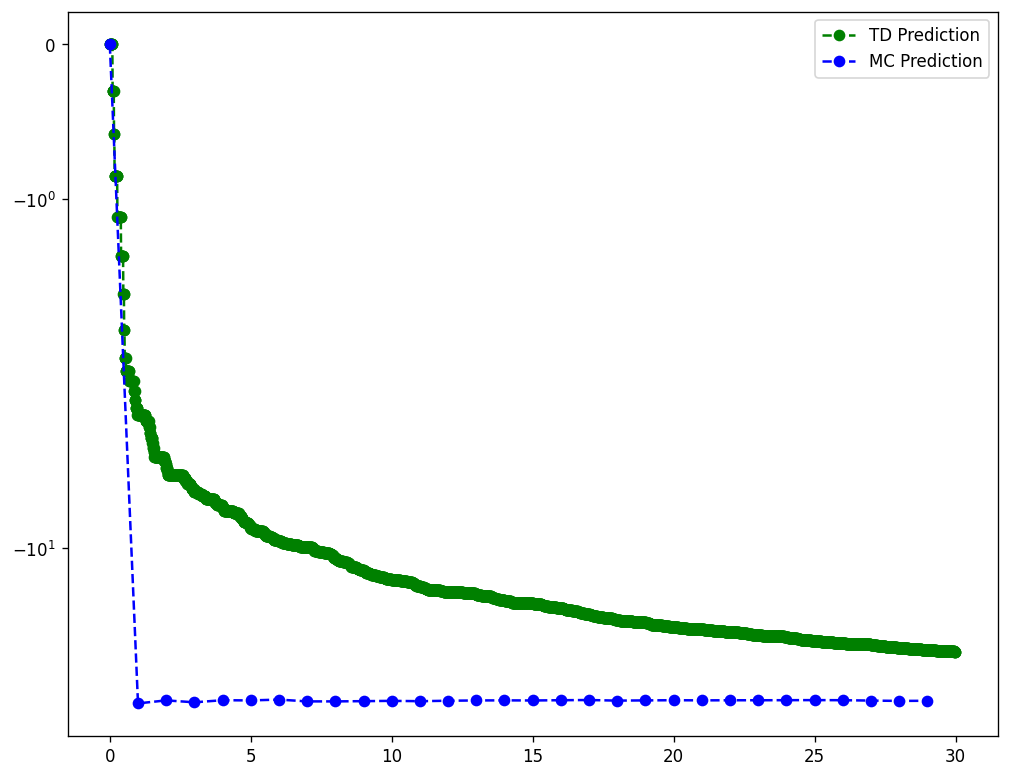

In [33]:
from matplotlib import pyplot as plt



plt.plot(td_x[:3000], td_state0[:3000], 'go--', label = "TD Prediction")
plt.plot(mc_x[:30], mc_state0[:30], 'bo--', label = "MC Prediction")
plt.yscale("symlog")
plt.legend()
fig = plt.gcf()
fig.set_size_inches((10,8))
fig.set_dpi(120)

We can see how the MC Prediction algorithm pretty much immediately goes to the optimal value function which might appear peculiar at first. However, our state space consists of only 6 non-terminal states, so when we run an episode of length 100, we get plenty of return, state pairs that can be averaged out for just one run. That's why there is only very small pertubations to this number after more runs of MC. TD on the other hand exhibits more of what we expect from the algorith: good increcemntal improvements from a steady stream of atomic experiences.